## Extract features for sepsis patients received propofol (induction). Some tables are obtained by running the official GitHub repo.

In [1]:
#libraries
import numpy as np
import pandas as pd
import psycopg2 #used to connect to our local MIMIC-III database
import collections
# import getpass
from datetime import datetime
import os,sys,re
import pickle
import csv
import math
#import seaborn as sns
# import random
from datetime import timedelta
from pathlib import Path
import importlib
import bisect
import glob
import copy


from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

#%load_ext autotime

{'width': 1024, 'height': 768, 'scroll': True}

In [2]:
dbname = 'mimiciv'
password = '15289943821'
user = 'postgres'
conn = psycopg2.connect(dbname=dbname, password=password,user=user)
cur=conn.cursor()

#####   icustay_id (MIMICIII) = stay_id (MIMICIV)

### SQL statement to build lab test table

In [ ]:
'''
DROP TABLE IF EXISTS public.pivoted_lab; CREATE TABLE public.pivoted_lab AS 

SELECT
  MAX(le.subject_id) AS subject_id,
  MAX(le.hadm_id) AS hadm_id,
  MAX(le.charttime) AS charttime,
  MAX(icu.stay_id) as stay_id,
  le.specimen_id, 
  MAX(CASE WHEN le.itemid = 50862 AND le.valuenum <= 10 THEN le.valuenum ELSE NULL END) AS albumin,
  MAX(CASE WHEN le.itemid = 50930 AND le.valuenum <= 10 THEN le.valuenum ELSE NULL END) AS globulin,
  MAX(CASE WHEN le.itemid = 50976 AND le.valuenum <= 20 THEN le.valuenum ELSE NULL END) AS total_protein,
  MAX(CASE WHEN le.itemid = 50868 AND le.valuenum <= 10000 THEN le.valuenum ELSE NULL END) AS aniongap,
  MAX(CASE WHEN le.itemid = 50882 AND le.valuenum <= 10000 THEN le.valuenum ELSE NULL END) AS bicarbonate,
  MAX(CASE WHEN le.itemid = 51006 AND le.valuenum <= 300 THEN le.valuenum ELSE NULL END) AS bun,
  MAX(CASE WHEN le.itemid = 50893 AND le.valuenum <= 10000 THEN le.valuenum ELSE NULL END) AS calcium,
  MAX(CASE WHEN le.itemid = 50902 AND le.valuenum <= 10000 THEN le.valuenum ELSE NULL END) AS chloride,
  MAX(CASE WHEN le.itemid = 50912 AND le.valuenum <= 150 THEN le.valuenum ELSE NULL END) AS creatinine,
  MAX(CASE WHEN le.itemid = 50931 AND le.valuenum <= 10000 THEN le.valuenum ELSE NULL END) AS glucose,
  MAX(CASE WHEN le.itemid = 50983 AND le.valuenum <= 200 THEN le.valuenum ELSE NULL END) AS sodium,
  MAX(CASE WHEN le.itemid = 50971 AND le.valuenum <= 30 THEN le.valuenum ELSE NULL END) AS potassium,
  MAX(CASE WHEN le.itemid = 51237 THEN le.valuenum ELSE NULL END) AS inr,
  MAX(CASE WHEN le.itemid = 51274 THEN le.valuenum ELSE NULL END) AS pt,
  MAX(CASE WHEN le.itemid = 51275 THEN le.valuenum ELSE NULL END) AS ptt,
  MAX(CASE WHEN le.itemid = 51221 THEN le.valuenum ELSE NULL END) AS hematocrit,
  MAX(CASE WHEN le.itemid = 51222 THEN le.valuenum ELSE NULL END) AS hemoglobin,
  MAX(CASE WHEN le.itemid = 51248 THEN le.valuenum ELSE NULL END) AS mch,
  MAX(CASE WHEN le.itemid = 51249 THEN le.valuenum ELSE NULL END) AS mchc,
  MAX(CASE WHEN le.itemid = 51250 THEN le.valuenum ELSE NULL END) AS mcv,
  MAX(CASE WHEN le.itemid = 51265 THEN le.valuenum ELSE NULL END) AS platelet,
  MAX(CASE WHEN le.itemid = 51279 THEN le.valuenum ELSE NULL END) AS rbc,
  MAX(CASE WHEN le.itemid = 51277 THEN le.valuenum ELSE NULL END) AS rdw,
  MAX(CASE WHEN le.itemid = 52159 THEN le.valuenum ELSE NULL END) AS rdwsd,
  MAX(CASE WHEN le.itemid = 51301 THEN le.valuenum ELSE NULL END) AS wbc
  
FROM public.labevents AS le join public.icustays icu on le.subject_id = icu.subject_id 
WHERE
  le.itemid IN (50862,50930,50976,50868 ,50882 ,51006 ,50893 ,50902 ,50912 ,50931,50983,50971 ,51237,51274,51275,51221,51222,
  51248,51249,51250 ,51265,51279 ,51277,52159 ,51301)
  AND NOT valuenum IS NULL
  AND /* lab values cannot be 0 and cannot be negative */ /* .. except anion gap. */ (
    valuenum > 0 OR itemid = 50868
  )
  AND icu.intime <= charttime AND charttime <= icu.outtime
  AND not icu.stay_id is null
GROUP BY
  le.specimen_id

'''

### Select sepsis cohort

In [3]:
query_sepsis = """
with ss as (
select sep.stay_id, info.age, info.is_male, info.is_black, info.is_multipleRace, info.is_white,
info.is_EASTERN, info.is_ASIAN, info.is_OTHER from public.sepsis3 sep join 
(select pt.subject_id, pt.anchor_age as age, case
                 WHEN pt.gender = 'M' then 1
                 else 0
                 end as is_male, 
                 case 
                 WHEN ad.race = 'BLACK/AFRICAN' then 1
                 else 0 
                 end as is_black,
                 case WHEN ad.race = 'MULTIPLE RACE/ETHNICITY' then 1
                 else 0 
                 end as is_multipleRace,
                 case WHEN ad.race = 'WHITE - OTHER EUROPEAN' then 1
                 else 0 
                 end as is_white,
                 case WHEN ad.race = 'WHITE - EASTERN EUROPEAN' then 1
                 else 0 
                 end as is_EASTERN,
                 case WHEN ad.race = 'ASIAN' then 1
                 else 0 
                 end as is_ASIAN,
                 case WHEN ad.race = 'OTHER' then 1
                 else 0 
                 end as is_OTHER
                 from  public.patients pt join public.admissions ad on pt.subject_id = ad.subject_id) info 
            on sep.subject_id= info.subject_id)

select ss.stay_id,  ss.age, ss.is_male, ss.is_black, ss.is_multipleRace, ss.is_white,
ss.is_EASTERN, ss.is_ASIAN, ss.is_OTHER,  mv.weight
from ss join (select DISTINCT mv.stay_id, mv.patientweight as weight from public.inputevents mv where 
 mv.itemid = 222168 and mv.ordercategorydescription = 'Drug Push') mv on ss.stay_id = 
mv.stay_id where 
"""
features = ['ss.age', 'ss.is_male', 'ss.is_black', 'ss.is_multipleRace', 'ss.is_white','ss.is_EASTERN', 
            'ss.is_ASIAN','ss.is_OTHER', 'mv.weight']

for i in features:
    query_sepsis +=  i + ' is not null and '
query_sepsis = query_sepsis[:-len(' and ')]

    
query_pivoted_lab = '''
select * from public.pivoted_lab where stay_id is not null
'''

sql_statement = '''
select * from (
with ss as (
'''\
+ query_sepsis + ' ),  pvl as (' \
+ query_pivoted_lab + ') '\
+'''
select pvl.subject_id as subject_id, ss.stay_id as stay_id, 
ss.age as age, ss.is_male as is_male, ss.is_black as is_black, ss.is_multipleRace as is_multipleRace, ss.is_white 
as is_white, ss.is_EASTERN as is_EASTERN,ss.is_ASIAN as is_ASIAN, ss.is_OTHER as is_OTHER,ss.weight as weight, 
pvl.charttime as pvl_charttime, pvl.aniongap as aniongap, pvl.albumin as albumin, 
pvl.bicarbonate as bicarbonate,  pvl.creatinine as creatinine,pvl.chloride as chloride,
pvl.hematocrit as hematocrit,pvl.hemoglobin as hemoglobin,
pvl.platelet as platelet,pvl.potassium as potassium,pvl.ptt as ptt,pvl.inr as inr,pvl.pt as pt,
pvl.sodium as sodium,pvl.bun as bun,pvl.wbc as wbc 
from ss join  pvl on ss.stay_id=pvl.stay_id
) cohort where cohort.stay_id in (select distinct stay_id from public.inputevents where itemid = 222168 and 
ordercategorydescription = 'Drug Push') and
cohort.stay_id in  (select distinct stay_id from public.chartevents where itemid = 223753)

''' 



ppt_df = pd.read_sql_query(sql_statement,conn) 
ppt_df

,subject_id,stay_id,age,is_male,is_black,is_multiplerace,is_white,is_eastern,is_asian,is_other,...,hematocrit,hemoglobin,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,11365767,30015010,57,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,69.1,NaN,NaN,NaN,NaN,NaN
1,11365767,30015010,57,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,69.1,NaN,NaN,NaN,NaN,NaN
2,11365767,30015010,57,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,69.1,NaN,NaN,NaN,NaN,NaN
3,11365767,30015010,57,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,69.1,NaN,NaN,NaN,NaN,NaN
4,11365767,30015010,57,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,69.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74472,13033327,39867250,49,0,0,0,0,0,0,0,...,30.6,9.0,569.0,NaN,NaN,NaN,NaN,NaN,NaN,13.4
74473,13033327,39867250,49,0,0,0,0,0,0,0,...,NaN,NaN,NaN,4.5,NaN,NaN,NaN,144.0,13.0,NaN
74474,13033327,39867250,49,0,0,0,0,0,0,0,...,25.2,8.2,716.0,NaN,NaN,NaN,NaN,NaN,NaN,28.4
74475,13033327,39867250,49,0,0,0,0,0,0,0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,144.0,16.0,NaN


In [4]:
def median_impute(df, columns):
    # df has column stay_id
    for col in columns:
        median = df[col].dropna(how='any').median() # global median
        stay_median = {}
        for stay,val in zip(df['stay_id'], df[col]):
            if stay not in stay_median:
                stay_median[stay] = []
            if not math.isnan(float(val)):
                stay_median[stay].append(float(val))
        stay_median1 = {}
        for i in stay_median:
            vals = stay_median[i]
            if len(vals) == 0:
                stay_median1[i] = median # global median
            else:
                stay_median1[i] = np.median(vals) # local median
        new_values = []
        for stay,val in zip(df['stay_id'], df[col]):
            if math.isnan(float(val)):
                new_values.append(stay_median1[stay])
            else:
                new_values.append(float(val))
        df[col] = new_values
    return df

def datetime_to_sec(df,time_col='charttime'):
    time_in_sec = []
    date_format = '%Y-%m-%d %H:%M:%S'
    for i in df[time_col]:
        time_in_sec.append(datetime.strptime(str(i),date_format).timestamp())
    df[time_col] = time_in_sec
    return df

def datetime_to_sec_entry(time):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(str(time),date_format).timestamp()

In [5]:
ppt_df = datetime_to_sec(ppt_df, time_col='pvl_charttime')
columns = ['aniongap', 'albumin','bicarbonate','creatinine','chloride', 'hematocrit',\
          'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'] # drop glucose
ppt_df = median_impute(ppt_df, columns)
ppt_df

,subject_id,stay_id,age,is_male,is_black,is_multiplerace,is_white,is_eastern,is_asian,is_other,...,hematocrit,hemoglobin,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,11365767,30015010,57,1,0,0,0,0,0,0,...,30.95,10.6,398.0,3.8,69.1,1.2,14.2,140.0,13.0,10.0
1,11365767,30015010,57,1,0,0,0,0,0,0,...,30.95,10.6,398.0,3.8,69.1,1.2,14.2,140.0,13.0,10.0
2,11365767,30015010,57,1,0,0,0,0,0,0,...,30.95,10.6,398.0,3.8,69.1,1.2,14.2,140.0,13.0,10.0
3,11365767,30015010,57,1,0,0,0,0,0,0,...,30.95,10.6,398.0,3.8,69.1,1.2,14.2,140.0,13.0,10.0
4,11365767,30015010,57,1,0,0,0,0,0,0,...,30.95,10.6,398.0,3.8,69.1,1.2,14.2,140.0,13.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74472,13033327,39867250,49,0,0,0,0,0,0,0,...,30.60,9.0,569.0,4.0,28.9,1.3,14.7,142.0,17.0,13.4
74473,13033327,39867250,49,0,0,0,0,0,0,0,...,26.30,8.3,542.0,4.5,28.9,1.3,14.7,144.0,13.0,12.2
74474,13033327,39867250,49,0,0,0,0,0,0,0,...,25.20,8.2,716.0,4.0,28.9,1.3,14.7,142.0,17.0,28.4
74475,13033327,39867250,49,0,0,0,0,0,0,0,...,26.30,8.3,542.0,4.0,28.9,1.3,14.7,144.0,16.0,12.2


### Extract vital signs and impute

In [7]:
def feature_dict(df, feature_start=2, stay=0, time=1):
    result = {}
    n = len(df)
    for i in range(n):
        row = list(df.iloc[i])
        stay_id = row[stay]
        charttime = row[time]
        features = row[feature_start:]
        if stay_id not in result:
            result[stay_id] = {}
        result[stay_id][charttime] = features
    return result 

file = './vital_df.pickle'
if os.path.exists(file):
    file = open(file,'rb')
    vital_dict = pickle.load(file) # {'stay_id:{charttime1:[features], charttime2:[features]}'}
else:    
    stay_id = []
    for i in ppt_df['stay_id']:
        stay_id.append(int(i))


    query_vital = '''
    select stay_id, charttime, heart_rate, sbp,dbp,mbp,resp_rate,temperature,spo2,glucose 
    from public.vitalsign where stay_id in (select stay_id from public.sepsis3)
    ''' 
    vital_df = pd.read_sql_query(query_vital,conn) 
    exclude = []
    row = 0
    for i in vital_df['stay_id']:
        if int(i) not in stay_id:
            exclude.append(row)
        row += 1
    vital_df.drop(exclude) # [stay_id, charttime, 'heart_rate', 'sbp','dbp','mbp','resp_rate','temperature','spo2','glucose']
    columns = ['heart_rate', 'sbp','dbp','mbp','resp_rate','temperature','spo2','glucose']
    vital_df = median_impute(vital_df,columns)
    vital_df = datetime_to_sec(vital_df)
    vital_dict = vital_df = feature_dict(vital_df, feature_start=2) # {'stay_id:{charttime1:[features], charttime2:[features]}'}
    file = open(file,"wb")
    pickle.dump(vital_dict, file)

### Convert lab DF into dictionary

In [8]:
stay_start = {}
for i,j in zip(ppt_df['stay_id'], ppt_df['pvl_charttime']):
    if i not in stay_start:
        stay_start[i] = []
    stay_start[i].append(j)
for i in stay_start:
    stay_start[i] = min(stay_start[i])

columns = ['subject_id','stay_id', 'pvl_charttime','age', 'is_black', 'is_multiplerace', 'is_white',\
            'is_eastern','is_asian', 'is_other',  'weight', \
           'aniongap', 'albumin','bicarbonate','creatinine',\
           'chloride', 'hematocrit','hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt', \
           'sodium', 'bun', 'wbc']
ppt_dict = ppt_df = feature_dict(ppt_df[columns], feature_start=4, stay=1, time=3) # [subject_id, stay_id, hadm_id,...]
# {'stay_id:{charttime1:[features], charttime2:[features]}'}

## Merge lab and vital signs

In [9]:
structural_features= {} # {'stay_id:{charttime1:[features], charttime2:[features]}'}
for stay in stay_start:
    start = stay_start[stay]
    lab_times = sorted(ppt_dict[stay].keys())
    temp = {}
    for vital_time in vital_dict[stay]:
        idx = bisect.bisect_left(lab_times, vital_time) - 1
        if idx < 0:
            continue
        lab_time = lab_times[idx]
        merged_features = copy.deepcopy(ppt_dict[stay][lab_time])
        merged_features.extend(vital_dict[stay][vital_time])
        temp[vital_time] = merged_features
    if len(temp) == 0:
        continue
    else:
        structural_features[stay] = temp

#del ppt_dict
#del vital_dict

## Extract treatment

In [11]:
file = './treatment.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    treatment_dict = pickle.load(file) #  {stay_id:{time1:dosage1, time2:dosage2}}
else:
    treatment_query = '''
    select stay_id, starttime, (amount / patientweight) as dosage_mg_kg 
    from public.inputevents where itemid=222168 and ordercategorydescription = 'Drug Push' 
    '''
    treatment_df = pd.read_sql_query(treatment_query,conn)
    treatment_dict = {}
    n = len(treatment_df)
    for i in range(n):
        stay_id, time, amount = list(treatment_df[['stay_id', 'starttime', 'dosage_mg_kg']].iloc[i])
        if stay_id not in stay_start:
            continue
        else:
            if stay_id not in treatment_dict:
                treatment_dict[stay_id] = {}
            treatment_dict[stay_id][datetime_to_sec_entry(time)] = amount
    del treatment_df
    file = open(file,"wb")
    pickle.dump(treatment_dict, file)

## Extract outcome

In [12]:
file = './outocmes.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    outcome_dict = pickle.load(file) #  {stay_id:{time1:SAS1, time2:SAS2}}
else:
    outcome_query = '''
    select stay_id, charttime, valuenum from public.chartevents where itemid = 223753 and 
    stay_id in (select stay_id from public.inputevents where itemid=222168 and ordercategorydescription = 'Drug Push')
    '''
    outcome_df = pd.read_sql_query(outcome_query,conn)
    outcome_dict = {}
    n = len(outcome_df)
    for i in range(n):
        stay_id, time, ss = list(outcome_df[['stay_id', 'charttime', 'valuenum']].iloc[i])
        if stay_id not in stay_start:
            continue
        else:
            if stay_id not in outcome_dict:
                outcome_dict[stay_id] = {}
            outcome_dict[stay_id][datetime_to_sec_entry(time)] = ss
    file = open(file,"wb")
    pickle.dump(outcome_dict, file)
    del outcome_df
    

## Merge features, dosage, outcome

In [13]:
## structural_features= {}  {'stay_id:{charttime1:[features], charttime2:[features]}'}
## treatment_dict = {} {stay_id:{time1:dosage1, time2:dosage2}}
## outcome_dict = {} {stay_id:{time1:SAS1, time2:SAS2}}
## stay_start {stay_id: starttime}

unique_stay = set()
all_data = []
maxtime_after_treatment = 1800 # sec, the maximum time after treatment that the label should be recorded

for stay in treatment_dict:
    if stay not in structural_features or stay not in outcome_dict:
        continue
    for treat_start in treatment_dict[stay]:
        temp = []
        # find features before treatment
        feature_times = sorted(list(structural_features[stay]))
        idx = bisect.bisect_left(feature_times, treat_start) - 1
        if idx < 0:
            continue
        features = structural_features[stay][feature_times[idx]]
        # find dosage
        dosage = treatment_dict[stay][treat_start]
        
        label_times = sorted(list(outcome_dict[stay]))
        idx = bisect.bisect_left(label_times, treat_start) - 1
        if idx < 0: 
            continue
        label_before_t = outcome_dict[stay][label_times[idx]] # label before treatment
        
        if label_before_t <= 3:
            continue # patient is sedated
        try:
            label_time = label_times[idx + 1]
        except:
            continue # no label
        # check if label is recorded too late
        if label_time - treat_start > maxtime_after_treatment:
            continue
        label_after_t = outcome_dict[stay][label_time]
        temp.append(label_after_t)
        temp.append(dosage)
        temp.extend(features)
        temp.append(label_before_t)
        all_data.append(temp)
        unique_stay.add(stay)

In [14]:
len(all_data)

177

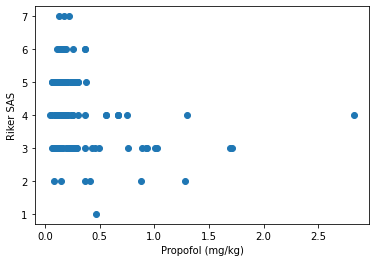

In [15]:
import matplotlib.pyplot as plt
plt.scatter(np.array(all_data)[:,1],np.array(all_data)[:,0])
plt.xlabel('Propofol (mg/kg)')
plt.ylabel('Riker SAS')
plt.show()

### Store data

In [16]:
for i in [structural_features, treatment_dict, outcome_dict, stay_start]:
    del i
def write_csv(outpath, data):
    with open(outpath, 'w',newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerows(data)
file = './mimiciv_seda_raw.csv'
write_csv(file, all_data)

### Find unique patient

In [17]:
sepsis_query = '''
select icu.subject_id, ss.stay_id from public.sepsis3 ss join public.icustays icu on 
ss.stay_id=icu.stay_id
'''
sepsis_df = pd.read_sql_query(sepsis_query,conn)
sepsis_dict = {} # {stay_id:subject_id}
n = len(sepsis_df)
for i in range(n):
    subject, stay = list(sepsis_df[['subject_id', 'stay_id']].iloc[i])
    if stay not in sepsis_dict:
        sepsis_dict[stay] = []
    sepsis_dict[stay].append(subject)
    
unique_subject = set()
for i in unique_stay:
    for j in sepsis_dict[i]:
        unique_subject.add(j)
print(('The number of unique subject: ', len(unique_subject)))

('The number of unique subject: ', 87)
